In [2]:
### Load PPS model
%run ./HC_model.ipynb

In [3]:
## Experiment function
def experimentrun_explore(
    a_distances, time, b=2.5, pr=0, L_ex=0.15, L_in=0.05, S_ex=1, S_in=4
):
    """Compute the RT of the network for the given distance points.

    Args:
        a_distances (1D array): Vector with the distances at which the auditory stimuli is delivered (cm).
        time (number): Running time of the experiment (ms)

        b (number): Maximum value of the feedback synapses to be used in unisensory areas.
        pr (number): Pruning threshold to be used in feedforward auditory synapses
        L_ex (number): Amplitude of excitatory synapses to be used in unisensory areas.
        L_in (number): Amplitude of inhibitory synapses to be used in unisensory areas.
        S_ex (number): Extension of excitatory synapses (cm) to be used in unisensory areas.
        S_in (number): Extension of inhibitory synapses (cm) to be used in unisensory areas.

    Returns:
        RTs (1D np.array): Vector with the RTs at the given distance points (ms).
        ZMs (2D np.array): Matrix with the activity of the multisensory neuron during the experiment at each distance point.
        ZTs (3D np.array): Array with the final activity of the tactile neurons at each distance point.
        ZAs (3D np.array): Array with the final activity of the auditory neurons at each distance point.
    """

    # Setup network synapses
    Lt, La = Lw(L_ex, L_in, S_ex, S_in, L_ex, L_in, S_ex * 20, S_in * 20)
    Wt, Wa, Bt, Ba = Fw(6.5, 6.5, b, b)
    PrWa = prun(Wa, pr)

    # Network computing parameters
    dt = 0.4
    dtau = dt / tau

    # Experiment parameters
    timesteps = int(time / dt)
    ndist = len(a_distances)

    # Build matrices to register network activity during the experiment
    RTs = np.zeros(ndist)
    ZTs = np.zeros((Mt, Nt, ndist))
    ZAs = np.zeros((Ma, Na, ndist))

    qt = np.zeros((Mt, Nt, timesteps + 1, ndist))
    ut = np.zeros((Mt, Nt, timesteps + 1, ndist))
    zt = np.zeros((Mt, Nt, timesteps + 1, ndist))
    pt = np.zeros((Mt, Nt, timesteps + 1, ndist))

    qa = np.zeros((Ma, Na, timesteps + 1, ndist))
    ua = np.zeros((Ma, Na, timesteps + 1, ndist))
    za = np.zeros((Ma, Na, timesteps + 1, ndist))
    pa = np.zeros((Ma, Na, timesteps + 1, ndist))

    qm = np.zeros((timesteps + 1, ndist))
    um = np.zeros((timesteps + 1, ndist))
    zm = np.zeros((timesteps + 1, ndist))
    pm = np.zeros((timesteps + 1, ndist))

    rt = np.zeros((timesteps + 1, ndist))

    # Generate a tactile stimulus
    ti = PHIt()

    # Run the experiment
    for d in range(ndist):
        xa_0 = a_distances[d]  # How far the sound is presented.
        ai = PHIa(xa_0)  # Generates an auditory input

        for i in range(timesteps):
            # Tactile activity
            ut[:, :, i + 1, d] = ti + LIt(zt[:, :, i, d], Lt) + bt(zm[i, d], Bt)
            qt[:, :, i + 1, d] = qt[:, :, i, d] + dtau * (
                -qt[:, :, i, d] + ut[:, :, i, d]
            )
            pt[:, :, i + 1, d] = psit(qt[:, :, i, d])
            zt[:, :, i + 1, d] = pt[:, :, i, d] * np.heaviside(pt[:, :, i, d], 0)

            # Auditory activity
            ua[:, :, i + 1, d] = ai + LIa(za[:, :, i, d], La) + ba(zm[i, d], Ba)
            qa[:, :, i + 1, d] = qa[:, :, i, d] + dtau * (
                -qa[:, :, i, d] + ua[:, :, i, d]
            )
            pa[:, :, i + 1, d] = psia(qa[:, :, i, d])
            za[:, :, i + 1, d] = pa[:, :, i, d] * np.heaviside(pa[:, :, i, d], 0)

            # Multisensory activity
            um[i + 1, d] = np.sum(np.multiply(Wt, zt[:, :, i, d])) + np.sum(
                np.multiply(PrWa, za[:, :, i, d])
            )
            qm[i + 1, d] = qm[i, d] + dtau * (-qm[i, d] + um[i, d])
            pm[i + 1, d] = psim(qm[i, d])
            zm[i + 1, d] = pm[i, d] * np.heaviside(pm[i, d], 0)

            # Network response
            rt[i + 1, d] = np.any(zt[:, :, i, d] > (0.9 * ft_max))

        # Compute RT
        RTs[d] = np.argmax(rt[:, d]) * dt

    return RTs, qm, qt, qa

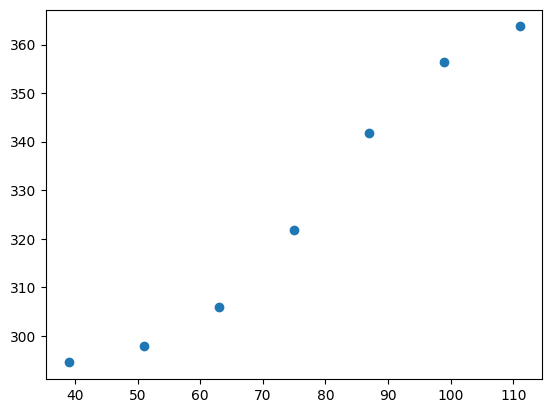

In [4]:
### Audio-tactile experiment simulation setup

## Calculate distance in cms. Speaker is positioned at 100cm from the hand.
s_distances = np.asarray([2700, 2200, 1500, 800, 300]) / 1000
ts = np.linspace(s_distances[0], s_distances[-1], 7)
v = 30  # cm/s
a_distances = 120 - ts * v  # distance points in cm (network coordinates)

## Simulation setup
simtime = 100  # ms

# Experimental Data
ymin = 292.67682496787893
ymax = 368.14828117144293
cp = 120 - 1.329 * v
slope = 1 / 0.09
HC_RTs = RTsig(a_distances, cp, slope)
plt.scatter(a_distances, HC_RTs)

In [5]:
hcRTs, hc_qm, hc_qt, hc_qa = experimentrun_explore(a_distances, simtime)
sczRTs, scz_qm, scz_qt, scz_qa = experimentrun_explore(
    a_distances, simtime, 2.5, 1.99620687, 0.99454028, 0.05, 1, 4
)

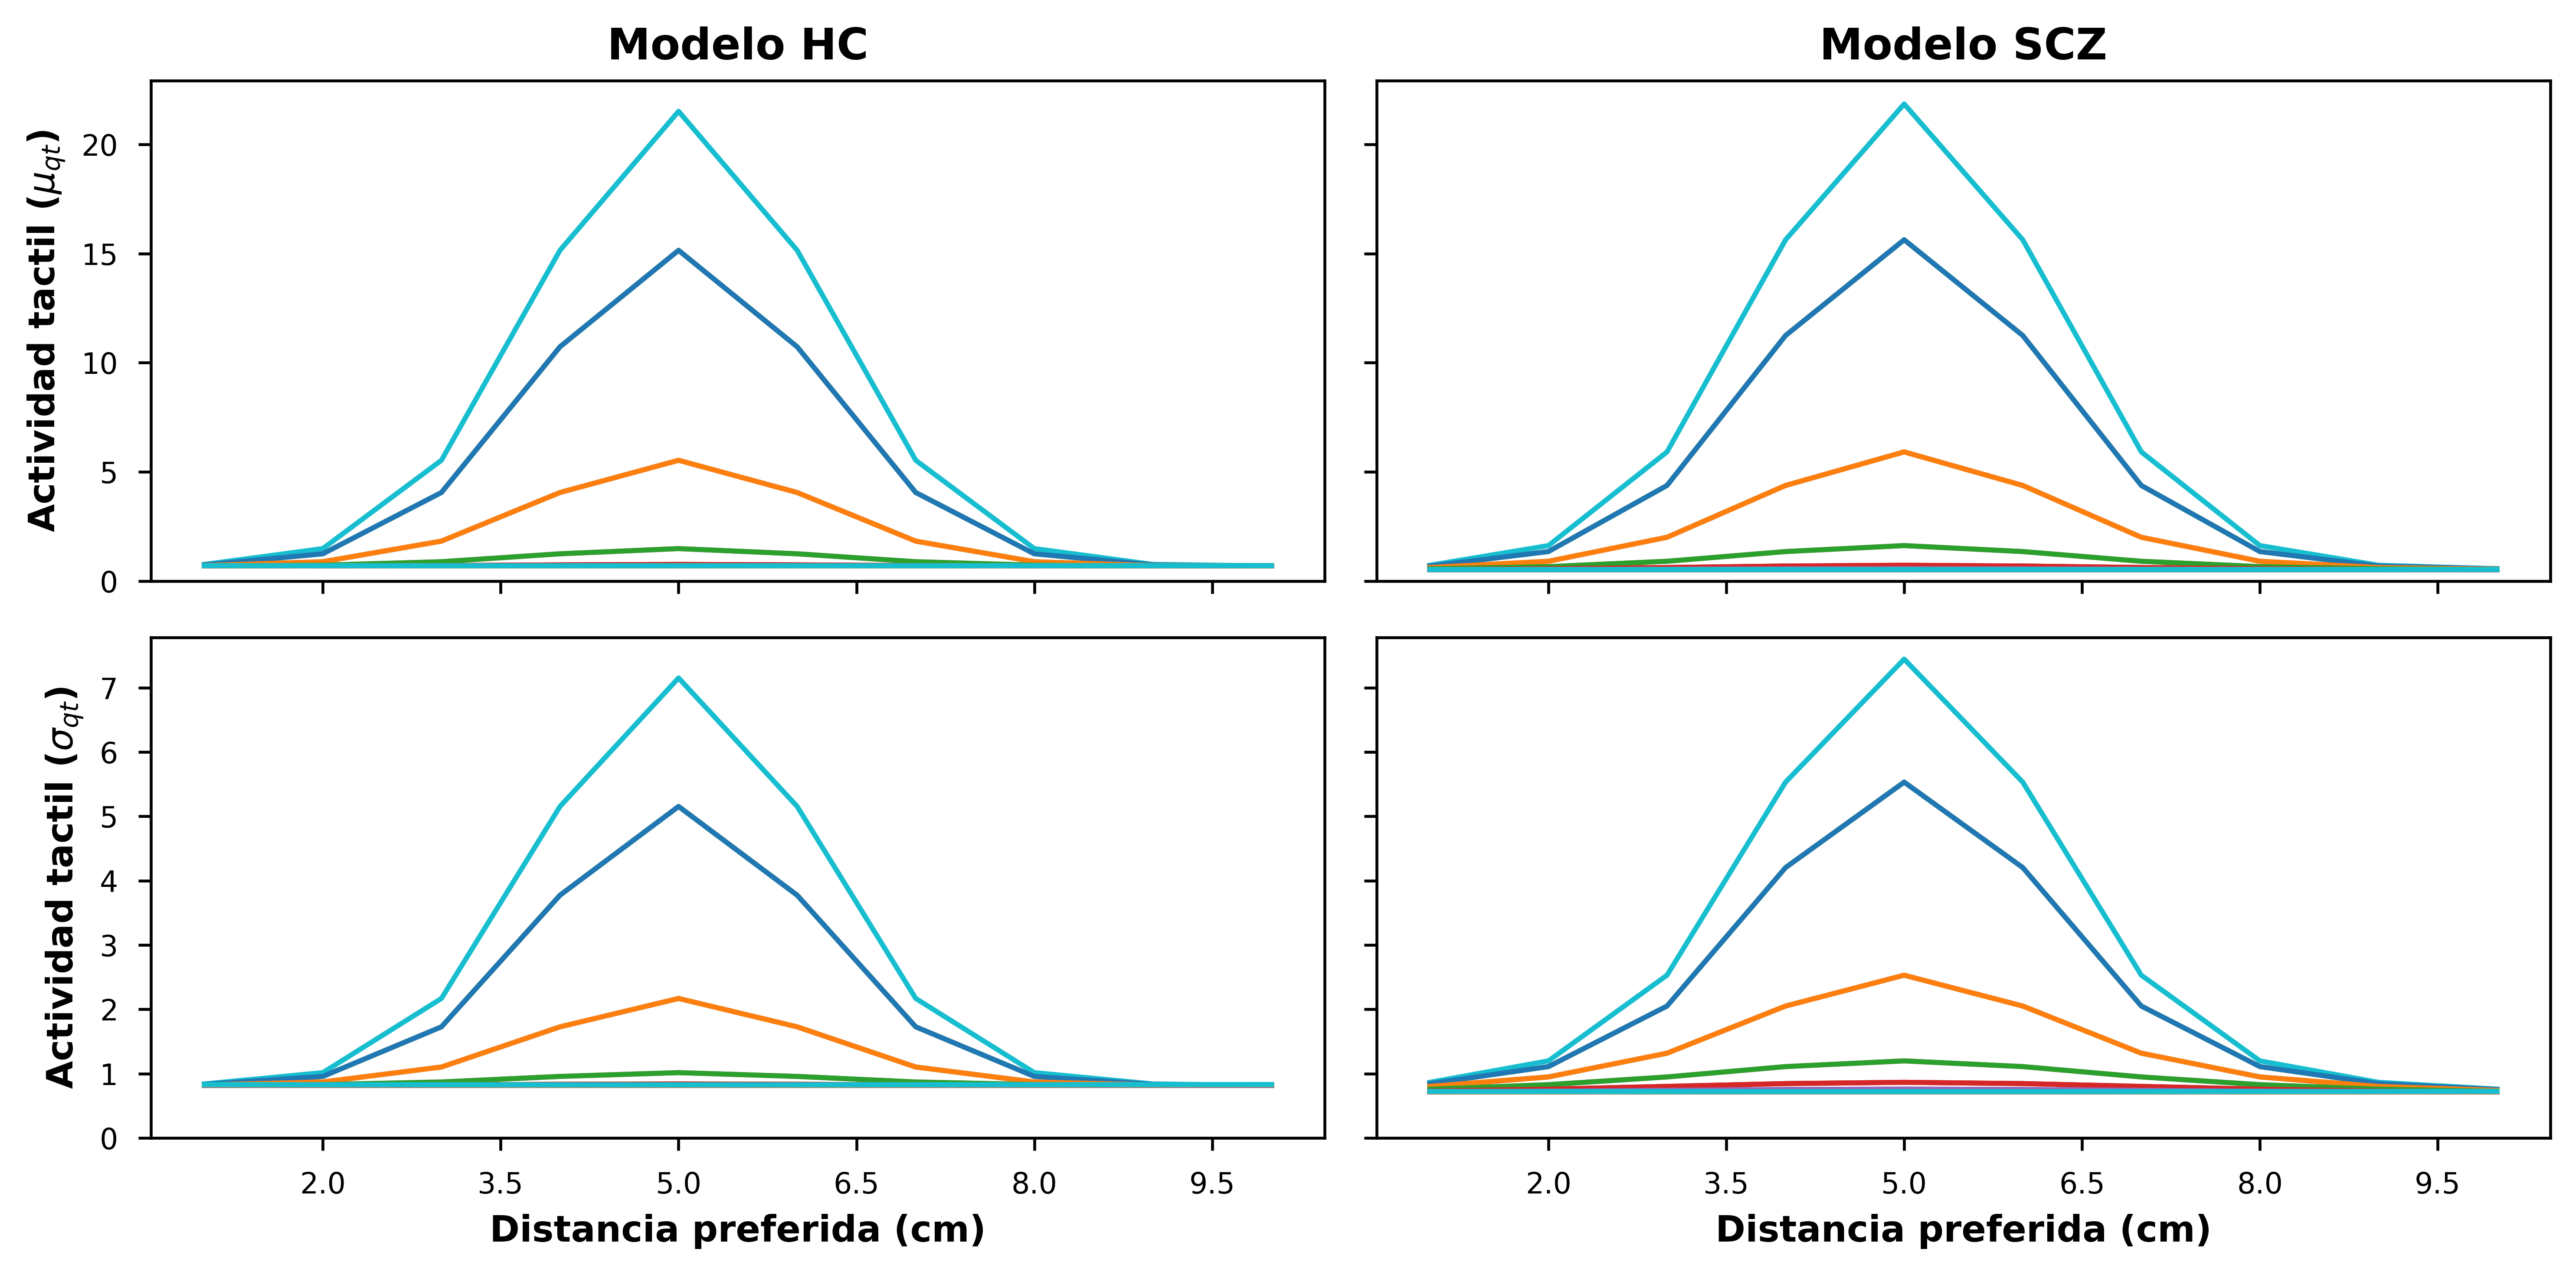

In [6]:
import string

plt.style.use("seaborn-v0_8-paper")

# initializes figure and plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey="row", dpi=600, sharex="all")


ax1 = plt.subplot(221)
ax1.plot(np.mean(hc_qt[:, :, :, 3], axis=2).T)
ax1.set_ylabel(r"Actividad tactil ($\mu_{qt}$)", size=10, weight="bold")
ax1.set_title("Modelo HC", weight="bold", size=12)
ax1.set_xticks(np.arange(-0.5, 9.5, 1.5))
ax1.set_xticklabels(np.arange(0.5, 10.5, 1.5))

ax2 = plt.subplot(222)
ax2.plot(np.mean(scz_qt[:, :, :, 3], axis=2).T)
ax2.set_title("Modelo SCZ", weight="bold", size=12)
ax2.set_ylim(
    0,
)

ax3 = plt.subplot(223)
ax3.plot(np.std(hc_qt[:, :, :, 3], axis=2).T)
ax3.set_ylabel(r"Actividad tactil ($\sigma_{qt}$)", size=10, weight="bold")
ax3.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")

ax4 = plt.subplot(224)
ax4.plot(np.std(scz_qt[:, :, :, 3], axis=2).T)
ax4.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")
ax4.set_ylim(
    0,
)

plt.tight_layout()

fig.savefig("Results/FIG_Extra_1.eps", bbox_inches="tight", format="eps")
fig.savefig("Results/FIG_Extra_1.png", bbox_inches="tight")

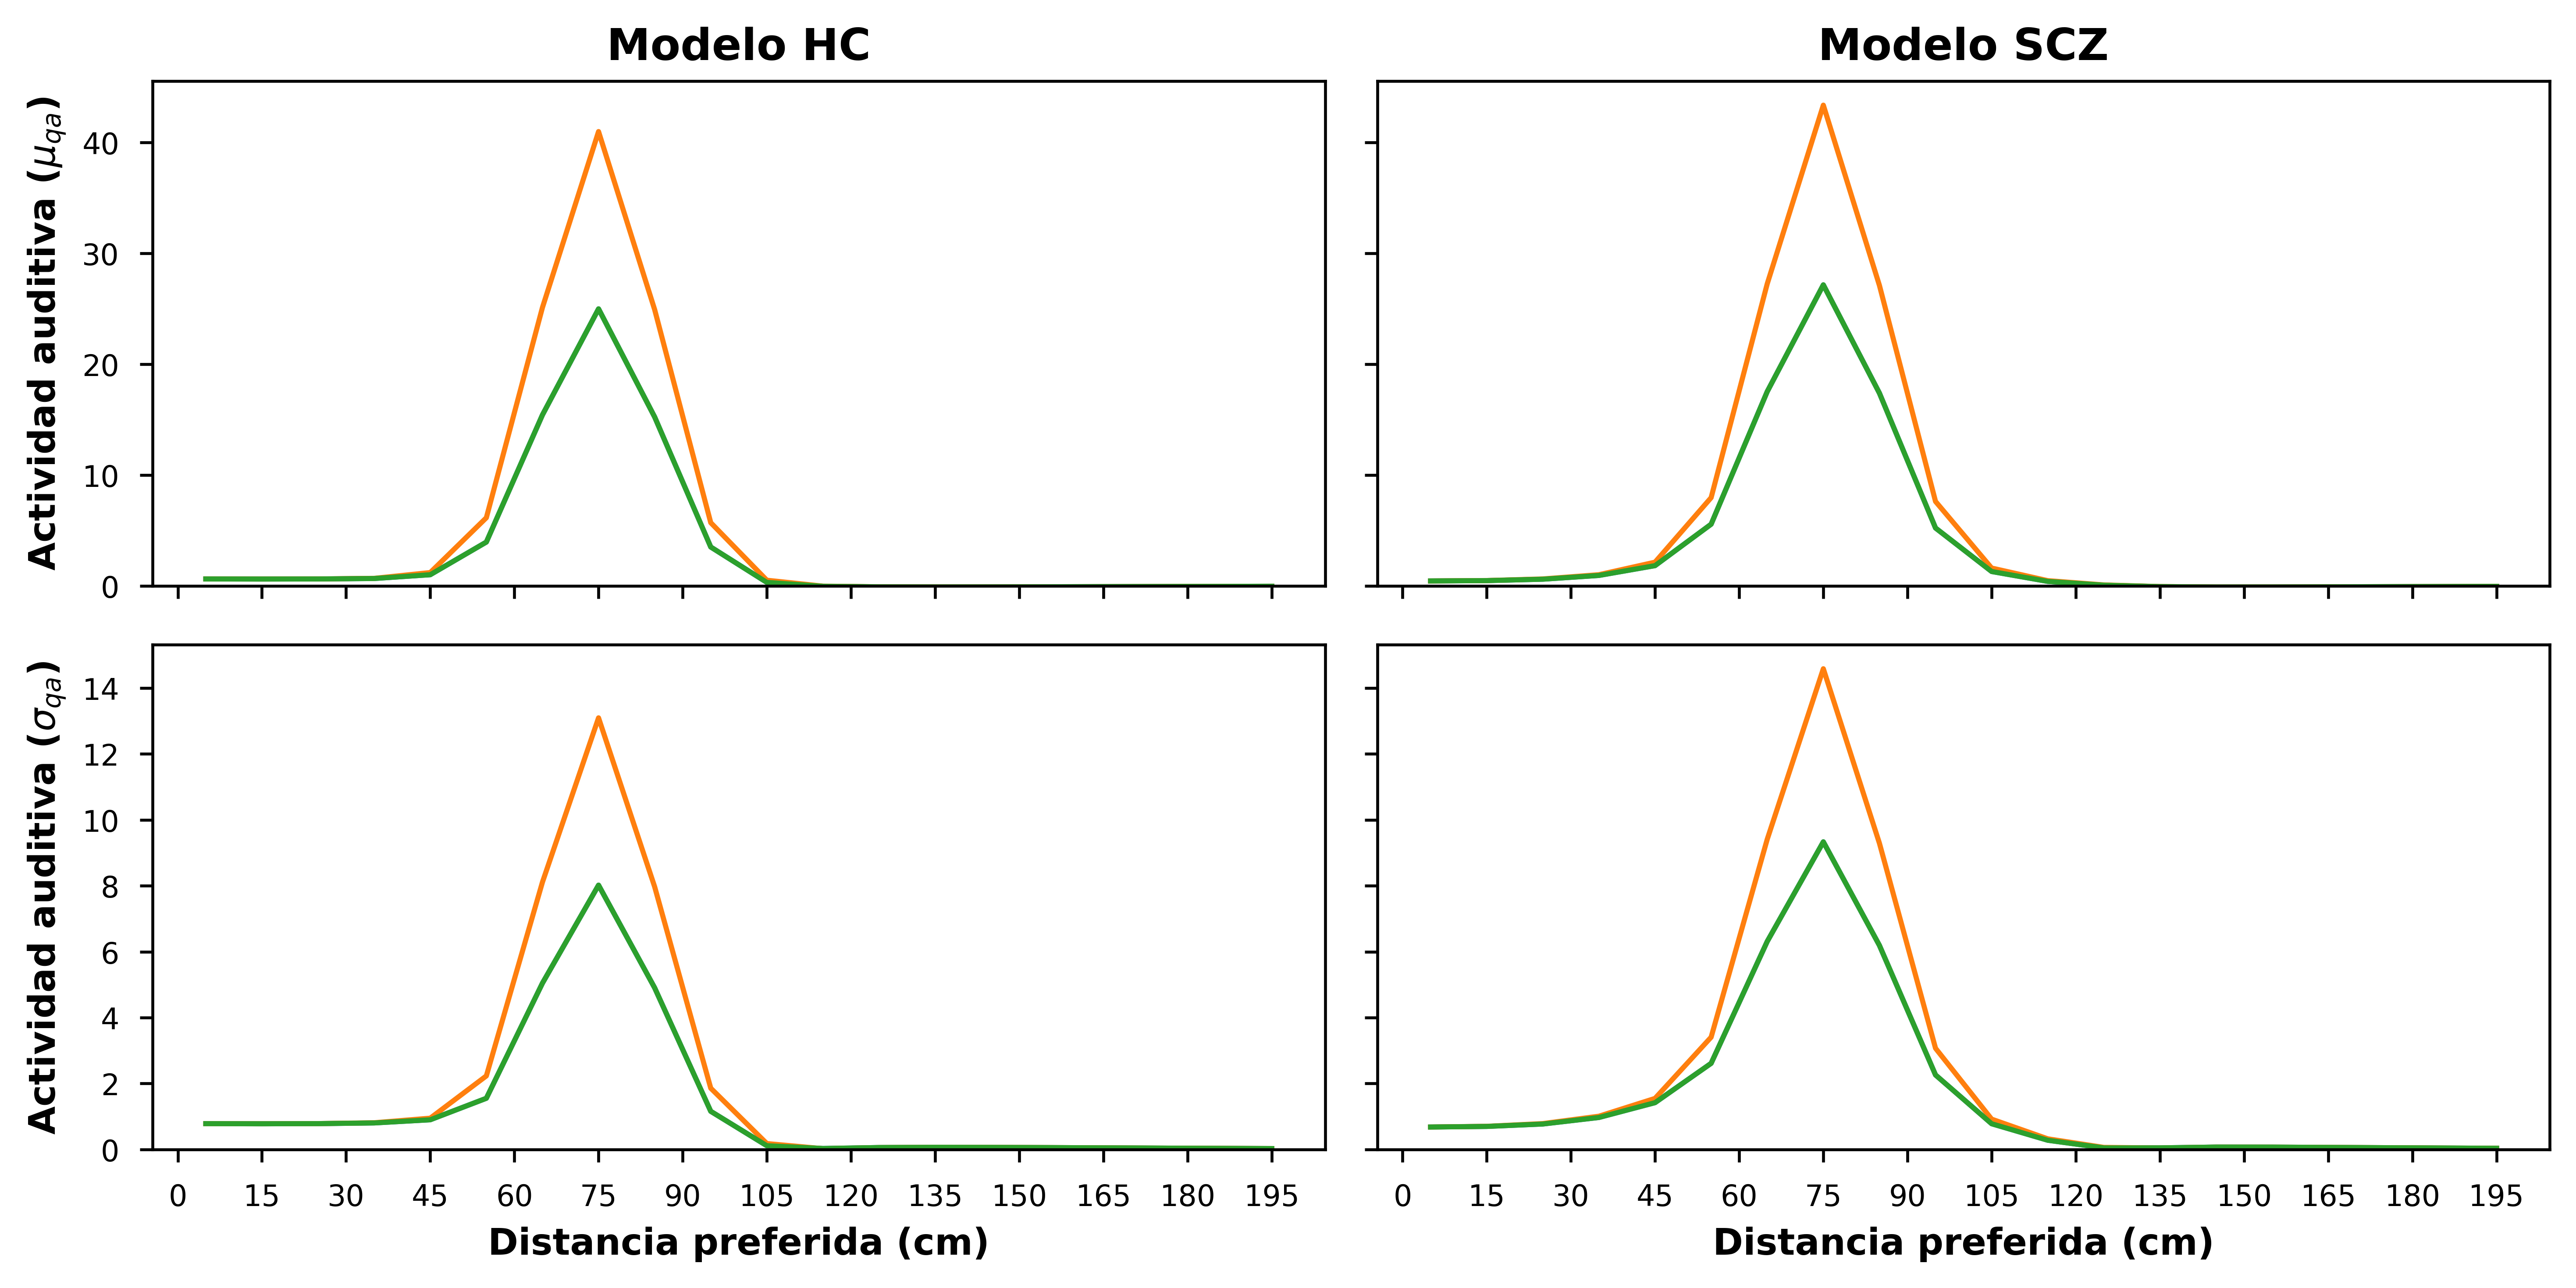

In [7]:
plt.style.use("seaborn-v0_8-paper")

# initializes figure and plots
fig, axs = plt.subplots(2, 2, figsize=(10, 5), sharey="row", dpi=600, sharex="all")


ax1 = plt.subplot(221)
ax1.plot(np.mean(hc_qa[:, :, :, 3], axis=2))
ax1.set_ylabel(r"Actividad auditiva ($\mu_{qa}$)", size=10, weight="bold")
ax1.set_title("Modelo HC", weight="bold", size=12)
ax1.set_xticks(np.arange(-0.5, 19.5, 1.5))
ax1.set_xticklabels(np.arange(0, 200, 15))

ax2 = plt.subplot(222)
ax2.plot(np.mean(scz_qa[:, :, :, 3], axis=2))
ax2.set_title("Modelo SCZ", weight="bold", size=12)
ax2.set_ylim(
    0,
)

ax3 = plt.subplot(223)
ax3.plot(np.std(hc_qa[:, :, :, 3], axis=2))
ax3.set_ylabel(r"Actividad auditiva ($\sigma_{qa}$)", size=10, weight="bold")
ax3.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")

ax4 = plt.subplot(224)
ax4.plot(np.std(scz_qa[:, :, :, 3], axis=2))
ax4.set_xlabel("Distancia preferida (cm)", size=10, weight="bold")
ax4.set_ylim(
    0,
)

plt.tight_layout()

fig.savefig("Results/FIG_Extra_2.eps", bbox_inches="tight", format="eps")
fig.savefig("Results/FIG_Extra_2.png", bbox_inches="tight")